In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load both datasets
df_original = pd.read_parquet("hf://datasets/pbevan11/aya_redteaming_mcai_eval/data/train-00000-of-00001.parquet")
df_revision = pd.read_parquet("hf://datasets/pbevan11/aya_redteaming_mcai_eval-revision-only2/data/train-00000-of-00001.parquet")

# remove 'ro_' from all column anems of df_revision
df_revision.columns = df_revision.columns.str.replace('ro_', '')
df_revision.columns = df_revision.columns.str.replace('-', '_')

def calculate_harmful_percentages(df, abl=False):
    total_responses = len(df)
    abliterated_harmful_percent=0

    if abl:
      abliterated_harmful_count = df["Abliterated_harmlessness"].value_counts().get("HARMFUL", 0)
      abliterated_harmful_percent = (abliterated_harmful_count / total_responses) * 100
    instruct_harmful_count = df["Instruct_harmlessness"].value_counts().get("HARMFUL", 0)
    baseline_harmful_count = df["Baseline_harmlessness"].value_counts().get("HARMFUL", 0)
    mcai_sft_harmful_count = df["MCAI_SFT_harmlessness"].value_counts().get("HARMFUL", 0)
    mcai_sft_dpo_harmful_count = df["MCAI_SFT_DPO_harmlessness"].value_counts().get("HARMFUL", 0)

    instruct_harmful_percent = (instruct_harmful_count / total_responses) * 100
    baseline_harmful_percent = (baseline_harmful_count / total_responses) * 100
    mcai_sft_harmful_percent = (mcai_sft_harmful_count / total_responses) * 100
    mcai_sft_dpo_harmful_percent = (mcai_sft_dpo_harmful_count / total_responses) * 100

    return {
        "Abliterated": abliterated_harmful_percent,
        "Instruct": instruct_harmful_percent,
        "Baseline": baseline_harmful_percent,
        "MCAI SFT": mcai_sft_harmful_percent,
        "MCAI SFT DPO": mcai_sft_dpo_harmful_percent
    }

def process_data(df, abl=False):
    languages = df["language"].unique()
    mcai_sft_dpo_relative_changes = []
    instruct_relative_changes = []
    abliterated_relative_changes = []

    for lang in languages:
        lang_df = df[df["language"] == lang]
        total_lang_responses = len(lang_df)

        baseline_harmful_count = lang_df["Baseline_harmlessness"].value_counts().get("HARMFUL", 0)
        mcai_sft_dpo_harmful_count = lang_df["MCAI_SFT_DPO_harmlessness"].value_counts().get("HARMFUL", 0)
        instruct_harmful_count = lang_df["Instruct_harmlessness"].value_counts().get("HARMFUL", 0)

        baseline_harmful_percent = (baseline_harmful_count / total_lang_responses) * 100
        mcai_sft_dpo_harmful_percent = (mcai_sft_dpo_harmful_count / total_lang_responses) * 100
        instruct_harmful_percent = (instruct_harmful_count / total_lang_responses) * 100

        mcai_sft_dpo_relative_change = ((mcai_sft_dpo_harmful_percent - baseline_harmful_percent) / baseline_harmful_percent) * 100
        instruct_relative_change = ((instruct_harmful_percent - baseline_harmful_percent) / baseline_harmful_percent) * 100

        mcai_sft_dpo_relative_changes.append(mcai_sft_dpo_relative_change)
        instruct_relative_changes.append(instruct_relative_change)

        if abl==True:
            abliterated_harmful_count = lang_df["Abliterated_harmlessness"].value_counts().get("HARMFUL", 0)
            abliterated_harmful_percent = (abliterated_harmful_count / total_lang_responses) * 100
            abliterated_relative_change = ((abliterated_harmful_percent - baseline_harmful_percent) / baseline_harmful_percent) * 100
            abliterated_relative_changes.append(abliterated_relative_change)

    return languages, np.array(mcai_sft_dpo_relative_changes), np.array(instruct_relative_changes), np.array(abliterated_relative_changes)

# Calculate harmful percentages
original_percentages = calculate_harmful_percentages(df_original)
revision_percentages = calculate_harmful_percentages(df_revision, abl=True)

print("Critique+Revision Dataset Harmful Percentages:")
for model, percentage in original_percentages.items():
    print(f"{model} harmful percent: {percentage:.2f}%")

print("\nRevision-Only Dataset Harmful Percentages:")
for model, percentage in revision_percentages.items():
    if 'MCAI' in model or 'Abliterated' in model:
        print(f"{model} harmful percent: {percentage:.2f}%")

Critique+Revision Dataset Harmful Percentages:
Abliterated harmful percent: 0.00%
Instruct harmful percent: 25.17%
Baseline harmful percent: 30.91%
MCAI SFT harmful percent: 45.10%
MCAI SFT DPO harmful percent: 24.83%

Revision-Only Dataset Harmful Percentages:
Abliterated harmful percent: 45.30%
MCAI SFT harmful percent: 41.95%
MCAI SFT DPO harmful percent: 13.93%


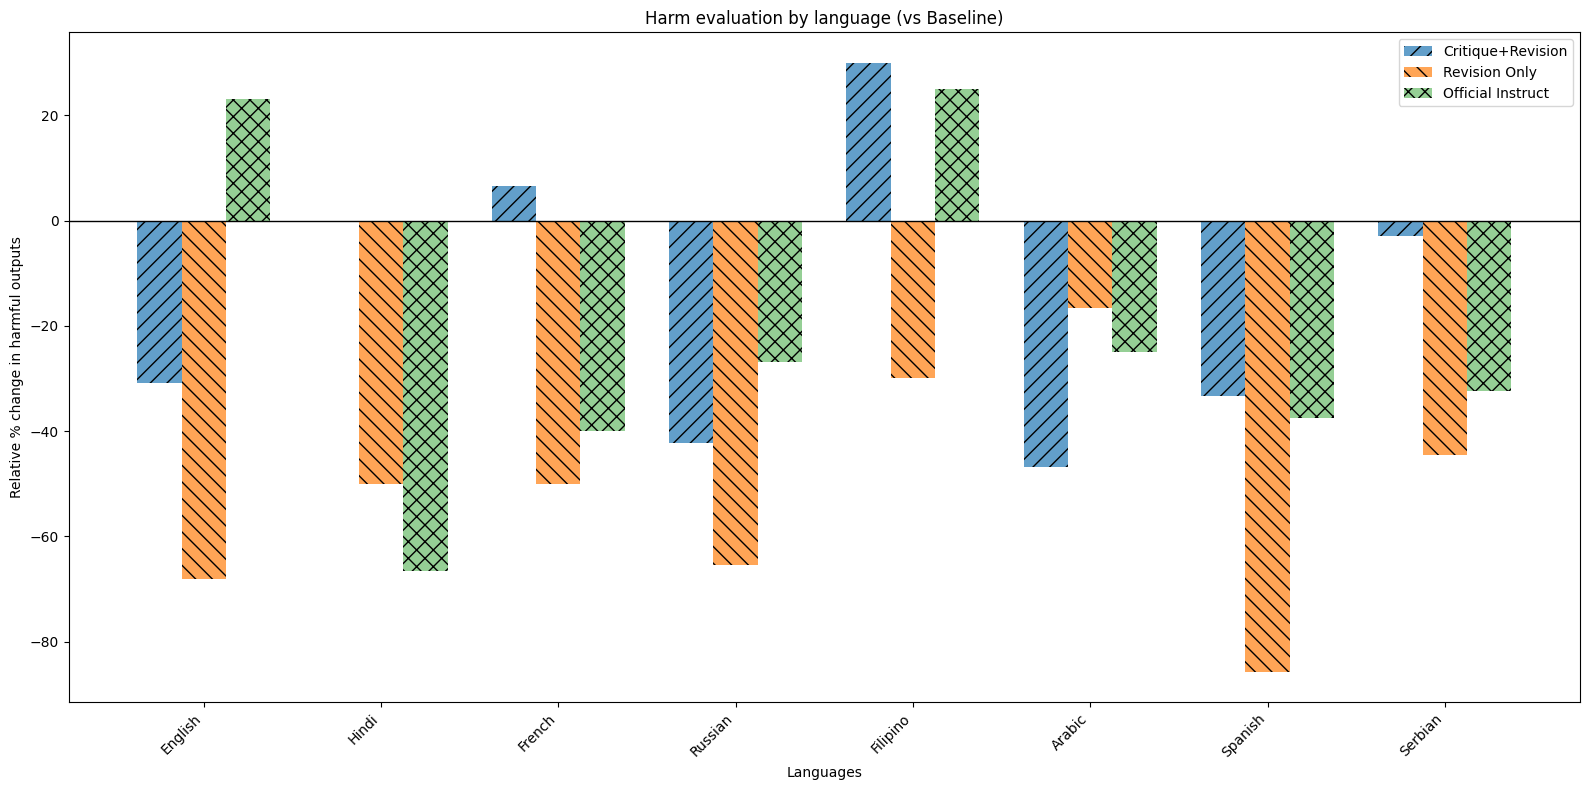


Summary Statistics:
Average relative change (Critique+Revision): -14.94
Average relative change (Revision Only): -51.3
Average relative change (Instruct): -22.55
Languages with bigger improvement in Critique+Revision vs Revision Only: 1
Languages with bigger improvement in Revision Only vs Critique+Revision: 7
Languages with bigger improvement in Critique+Revision vs Instruct: 3
Languages with bigger improvement in Instruct vs Critique+Revision: 5


In [7]:
languages_original, changes_original, instruct_changes_original, _ = process_data(df_original)
languages_revision, changes_revision, instruct_changes_revision, _ = process_data(df_revision)

# Ensure we're using the same languages for both datasets
common_languages = list(set(languages_original) & set(languages_revision))
changes_original = [changes_original[np.where(languages_original == lang)[0][0]] for lang in common_languages]
changes_revision = [changes_revision[np.where(languages_revision == lang)[0][0]] for lang in common_languages]
instruct_changes_original = [instruct_changes_original[np.where(languages_original == lang)[0][0]] for lang in common_languages]

# Create the grouped bar chart
bar_width = 0.25
index = np.arange(len(common_languages))

fig, ax = plt.subplots(figsize=(16, 8))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
bars1 = ax.bar(index - bar_width, changes_original, bar_width, label="Critique+Revision", color=colors[0], alpha=0.7, hatch="//")
bars2 = ax.bar(index, changes_revision, bar_width, label="Revision Only", color=colors[1], alpha=0.7, hatch="\\\\")
bars3 = ax.bar(index + bar_width, instruct_changes_original, bar_width, label="Official Instruct", color=colors[2], alpha=0.5, hatch="xx")

ax.set_xlabel("Languages")
ax.set_ylabel("Relative % change in harmful outputs")
ax.set_title("Harm evaluation by language (vs Baseline)")
ax.set_xticks(index)
ax.set_xticklabels(common_languages, rotation=45, ha='right')
ax.axhline(0, color="black", linewidth=1)
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("Average relative change (Critique+Revision):", round(np.mean(changes_original), 2))
print("Average relative change (Revision Only):", round(np.mean(changes_revision), 2))
print("Average relative change (Instruct):", round(np.mean(instruct_changes_original), 2))
print("Languages with bigger improvement in Critique+Revision vs Revision Only:", sum(o < r for o, r in zip(changes_original, changes_revision)))
print("Languages with bigger improvement in Revision Only vs Critique+Revision:", sum(o > r for o, r in zip(changes_original, changes_revision)))
print("Languages with bigger improvement in Critique+Revision vs Instruct:", sum(o < i for o, i in zip(changes_original, instruct_changes_original)))
print("Languages with bigger improvement in Instruct vs Critique+Revision:", sum(o > i for o, i in zip(changes_original, instruct_changes_original)))

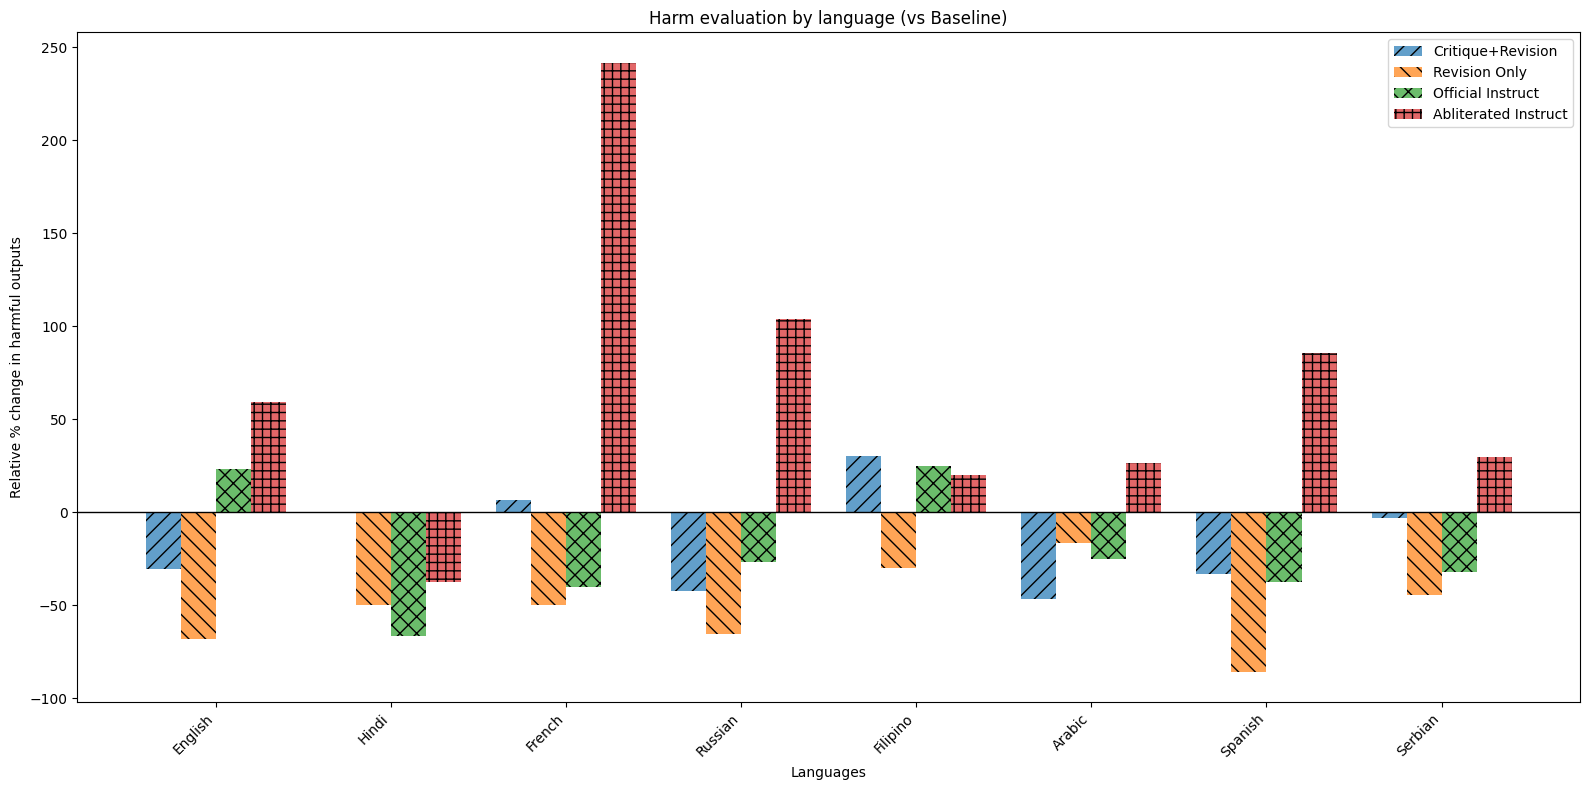


Summary Statistics:
Average relative change (Critique+Revision): -14.94
Average relative change (Revision Only): -51.3
Average relative change (Official Instruct): -22.55
Average relative change (Abliterated Instruct): 66.14
Languages with bigger improvement in Critique+Revision vs Revision Only: 1
Languages with bigger improvement in Revision Only vs Critique+Revision: 7
Languages with bigger improvement in Critique+Revision vs Official Instruct: 3
Languages with bigger improvement in Official Instruct vs Critique+Revision: 5
Languages with bigger improvement in Critique+Revision vs Abliterated Instruct: 6
Languages with bigger improvement in Abliterated Instruct vs Critique+Revision: 2


In [4]:
import numpy as np
import matplotlib.pyplot as plt

languages_original, changes_original, instruct_changes_original, _ = process_data(df_original)
languages_revision, changes_revision, instruct_changes_revision, abliterated_changes = process_data(df_revision, abl=True)

# Ensure we're using the same languages for both datasets
common_languages = list(set(languages_original) & set(languages_revision))
changes_original = [changes_original[np.where(languages_original == lang)[0][0]] for lang in common_languages]
changes_revision = [changes_revision[np.where(languages_revision == lang)[0][0]] for lang in common_languages]
instruct_changes_original = [instruct_changes_original[np.where(languages_original == lang)[0][0]] for lang in common_languages]
abliterated_changes = [abliterated_changes[np.where(languages_revision == lang)[0][0]] for lang in common_languages]

# Create the grouped bar chart
bar_width = 0.2
index = np.arange(len(common_languages))

fig, ax = plt.subplots(figsize=(16, 8))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red
bars1 = ax.bar(index - 1.5*bar_width, changes_original, bar_width, label="Critique+Revision", color=colors[0], alpha=0.7, hatch="//")
bars2 = ax.bar(index - 0.5*bar_width, changes_revision, bar_width, label="Revision Only", color=colors[1], alpha=0.7, hatch="\\\\")
bars3 = ax.bar(index + 0.5*bar_width, instruct_changes_original, bar_width, label="Official Instruct", color=colors[2], alpha=0.7, hatch="xx")
bars4 = ax.bar(index + 1.5*bar_width, abliterated_changes, bar_width, label="Abliterated Instruct", color=colors[3], alpha=0.7, hatch="++")

ax.set_xlabel("Languages")
ax.set_ylabel("Relative % change in harmful outputs")
ax.set_title("Harm evaluation by language (vs Baseline)")
ax.set_xticks(index)
ax.set_xticklabels(common_languages, rotation=45, ha='right')
ax.axhline(0, color="black", linewidth=1)
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("Average relative change (Critique+Revision):", round(np.mean(changes_original), 2))
print("Average relative change (Revision Only):", round(np.mean(changes_revision), 2))
print("Average relative change (Official Instruct):", round(np.mean(instruct_changes_original), 2))
print("Average relative change (Abliterated Instruct):", round(np.mean(abliterated_changes), 2))
print("Languages with bigger improvement in Critique+Revision vs Revision Only:", sum(o < r for o, r in zip(changes_original, changes_revision)))
print("Languages with bigger improvement in Revision Only vs Critique+Revision:", sum(o > r for o, r in zip(changes_original, changes_revision)))
print("Languages with bigger improvement in Critique+Revision vs Official Instruct:", sum(o < i for o, i in zip(changes_original, instruct_changes_original)))
print("Languages with bigger improvement in Official Instruct vs Critique+Revision:", sum(o > i for o, i in zip(changes_original, instruct_changes_original)))
print("Languages with bigger improvement in Critique+Revision vs Abliterated Instruct:", sum(o < a for o, a in zip(changes_original, abliterated_changes)))
print("Languages with bigger improvement in Abliterated Instruct vs Critique+Revision:", sum(o > a for o, a in zip(changes_original, abliterated_changes)))

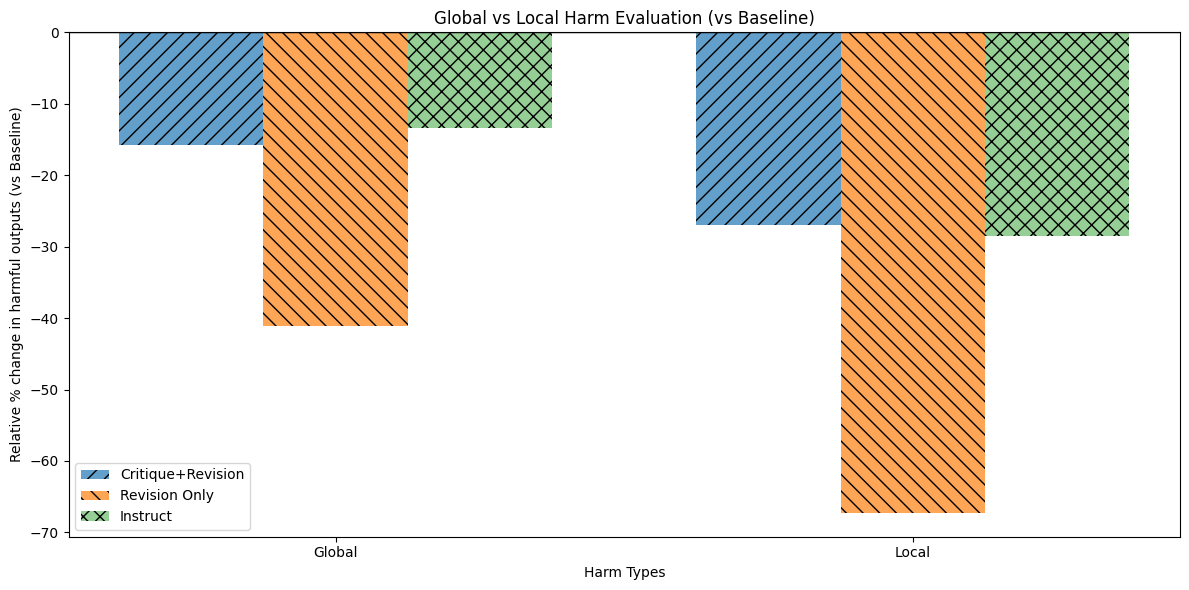

Summary Statistics:
Critique+Revision Dataset - Global harm change: -15.83%, Local harm change: -26.98%
Revision Dataset - Global harm change: -41.12%, Local harm change: -67.24%
Instruct Dataset - Global harm change: -13.33%, Local harm change: -28.57%
Difference (Critique+Revision - Revision) - Global: 25.29%, Local: 40.26%
Difference (Critique+Revision - Instruct) - Global: -2.50%, Local: 1.59%


In [ ]:
def calculate_global_local_changes(df):
    global_local_groups = df.groupby("global_or_local")
    harm_types = ["global", "local"]
    mcai_sft_dpo_relative_changes = []
    instruct_relative_changes = []

    for harm_type in harm_types:
        harm_df = global_local_groups.get_group(harm_type)
        total_harm_responses = len(harm_df)

        baseline_harmful_count = harm_df["Baseline_harmlessness"].value_counts().get("HARMFUL", 0)
        mcai_sft_dpo_harmful_count = harm_df["MCAI_SFT_DPO_harmlessness"].value_counts().get("HARMFUL", 0)
        instruct_harmful_count = harm_df["Instruct_harmlessness"].value_counts().get("HARMFUL", 0)

        baseline_harmful_percent = (baseline_harmful_count / total_harm_responses) * 100
        mcai_sft_dpo_harmful_percent = (mcai_sft_dpo_harmful_count / total_harm_responses) * 100
        instruct_harmful_percent = (instruct_harmful_count / total_harm_responses) * 100

        mcai_sft_dpo_relative_change = ((mcai_sft_dpo_harmful_percent - baseline_harmful_percent) / baseline_harmful_percent) * 100
        instruct_relative_change = ((instruct_harmful_percent - baseline_harmful_percent) / baseline_harmful_percent) * 100

        mcai_sft_dpo_relative_changes.append(mcai_sft_dpo_relative_change)
        instruct_relative_changes.append(instruct_relative_change)

    return mcai_sft_dpo_relative_changes, instruct_relative_changes

# Calculate relative changes for both datasets
original_changes, original_instruct_changes = calculate_global_local_changes(df_original)
revision_changes, _ = calculate_global_local_changes(df_revision)

# Set up the plot
harm_types = ["Global", "Local"]
bar_width = 0.25
index = np.arange(len(harm_types))

fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # Blue, Orange, Green
bars1 = ax.bar(index - bar_width, original_changes, bar_width, label="Critique+Revision", color=colors[0], alpha=0.7, hatch="//")
bars2 = ax.bar(index, revision_changes, bar_width, label="Revision Only", color=colors[1], alpha=0.7, hatch="\\\\")
bars3 = ax.bar(index + bar_width, original_instruct_changes, bar_width, label="Instruct", color=colors[2], alpha=0.5, hatch="xx")

ax.set_xlabel("Harm Types")
ax.set_ylabel("Relative % change in harmful outputs (vs Baseline)")
ax.set_title("Global vs Local Harm Evaluation (vs Baseline)")
ax.set_xticks(index)
ax.set_xticklabels(harm_types)
ax.legend()
ax.axhline(0, color="black", linewidth=1)

plt.tight_layout()
plt.show()

print("Summary Statistics:")
print(f"Critique+Revision Dataset - Global harm change: {original_changes[0]:.2f}%, Local harm change: {original_changes[1]:.2f}%")
print(f"Revision Dataset - Global harm change: {revision_changes[0]:.2f}%, Local harm change: {revision_changes[1]:.2f}%")
print(f"Instruct Dataset - Global harm change: {original_instruct_changes[0]:.2f}%, Local harm change: {original_instruct_changes[1]:.2f}%")
print(f"Difference (Critique+Revision - Revision) - Global: {original_changes[0] - revision_changes[0]:.2f}%, Local: {original_changes[1] - revision_changes[1]:.2f}%")
print(f"Difference (Critique+Revision - Instruct) - Global: {original_changes[0] - original_instruct_changes[0]:.2f}%, Local: {original_changes[1] - original_instruct_changes[1]:.2f}%")